In [2]:
import pandas as pd
from fastparquet import ParquetFile
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import shap
from utils import feature_drop, remove_highly_correlated_features
from sklearn.metrics import  roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor

In [3]:
file_path = "Data/train_ai_comp_final_dp.parquet"
pf = ParquetFile(file_path)
df = pf.to_pandas()
df = feature_drop(df)
df.head()

,id,target,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076
0,0,0,1761,1759,85,105469,191,46,0,6,...,28913,48985,84264,12045,12107,12510,21126,28913,48985,84264
1,1,0,1761,1759,120,105610,144,71,0,135,...,0,0,0,0,0,0,0,0,0,0
2,2,0,890,1759,141,105227,191,11,0,0,...,55949,70006,113317,33735,31242,12691,48682,55949,70006,113317
5,5,0,1599,966,30,102441,191,8,0,0,...,0,6872,8530,0,0,0,0,0,6872,8530
6,6,0,1761,1759,85,104006,191,2,0,0,...,0,0,7642,0,0,0,0,0,0,7642


### Удаление по корреляции

In [4]:
fature_to_drop = remove_highly_correlated_features(df, threshold=0.95)
df.drop(columns=fature_to_drop, inplace=True)

In [5]:
df.head()

,id,target,feature1,feature4,feature5,feature9,feature12,feature17,feature18,feature19,...,feature1056,feature1057,feature1058,feature1059,feature1063,feature1064,feature1065,feature1066,feature1068,feature1069
0,0,0,1761,105469,191,95,20,60,7,248,...,0,0,0,0,12045,12107,12510,21126,48985,84264
1,1,0,1761,105610,144,135,187,101,11,18,...,0,0,0,0,0,0,0,0,0,0
2,2,0,890,105227,191,0,187,0,28,248,...,0,0,0,0,33735,31242,12691,48682,70006,113317
5,5,0,1599,102441,191,0,187,0,28,248,...,5220,0,0,5810,0,0,0,0,6872,8530
6,6,0,1761,104006,191,46,2,21,3,248,...,0,0,0,0,0,0,0,0,0,7642


### Деление на train, test, validation

In [6]:
X = df.drop(columns=['target', "id"])
y = df['target']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Отбор по Mutal Info

In [7]:
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=100000, random_state=42, stratify=y_train)


In [8]:
X_sample

,feature1,feature4,feature5,feature9,feature12,feature17,feature18,feature19,feature22,feature23,...,feature1056,feature1057,feature1058,feature1059,feature1063,feature1064,feature1065,feature1066,feature1068,feature1069
224294,531,87836,191,298,187,275,28,248,140184,9,...,0,0,0,0,0,0,0,0,0,0
222846,1666,103688,191,142,70,63,11,248,140184,9,...,0,0,0,0,0,0,0,0,0,0
388567,1761,103219,191,0,77,0,28,248,140184,9,...,0,0,0,0,0,0,0,0,0,0
657619,1761,97743,191,41,63,1,3,248,140184,9,...,0,0,0,0,0,0,0,0,29173,34620
374392,1472,105146,191,17,61,17,1,248,140184,9,...,0,0,0,0,0,8615,0,8426,27137,31901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105324,1642,104861,16,16,138,2,1,155,40106,9,...,0,0,0,0,0,0,44720,0,74154,99832
126657,1761,103959,11,0,187,0,28,217,6052,9,...,0,0,0,0,0,0,0,0,0,0
112472,1761,92510,128,25,187,15,2,18,136555,9,...,0,0,0,0,0,0,0,0,0,0
113095,1761,102609,191,298,187,275,28,248,140184,9,...,0,0,0,0,0,0,0,0,0,0


In [9]:
mi_scores = mutual_info_classif(X_sample.dropna(axis=1), y_sample)
threshold = np.median(mi_scores)  # Например, можно выбрать среднее значение взаимной информации как порог
selected_features_indices = [i for i, mi_score in enumerate(mi_scores) if mi_score > threshold]

# Используем отобранные признаки для дальнейшей работы
selected_features_names = X_sample.dropna(axis=1).columns[selected_features_indices]

# Теперь используем эти имена для выбора столбцов из X_train и X_test
X_train_selected = X_train[selected_features_names]
X_test_selected = X_test[selected_features_names]

# Проверяем первые строки X_test_selected
X_test_selected.head()

,feature5,feature12,feature22,feature23,feature24,feature26,feature27,feature30,feature31,feature33,...,feature925,feature927,feature935,feature936,feature937,feature945,feature946,feature947,feature990,feature1000
110947,94,106,0,9,248,5,8,1738,536,50524,...,31,31,62319,198929,152144,78495,225035,167953,1,4
179283,191,187,140184,9,248,5,8,1738,633,50524,...,31,31,62319,198929,152144,78495,225035,167953,2,2
453240,191,187,140184,9,248,5,8,1738,633,50524,...,2,31,62319,198929,152144,78495,225035,167953,1,1
408592,19,42,115837,9,248,5,8,975,633,50524,...,31,1,62319,198929,152144,78495,225035,167953,1,2
37285,147,187,74352,9,248,5,8,1738,633,50524,...,31,31,25818,76344,152144,31163,100076,12676,3,4


In [10]:
with open('feature.txt', 'w', encoding='utf-8') as file:
    # Проходим по каждому элементу списка и записываем его в файл
    for item in selected_features_names:
        file.write("%s\n" % item)

In [11]:
X_test, X_train, X_val = X_test[selected_features_names], X_train[selected_features_names], X_val[selected_features_names]

In [12]:
X_test.shape, X_train.shape, X_val.shape

((77943, 341), (363730, 341), (77942, 341))

### LightGBM на отобранных фичах

In [13]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'gain',
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0,
    'n_estimators': 10000,
    'num_leaves': 31,
    'objective': "binary",
    'random_state': 9,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'metric': 'auc',
    'gpu_use_dp': True,
    "early_stopping_rounds":300
}

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

lightgbm = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, val_data])
y_train_pred = lightgbm.predict(X_train)
y_val_pred = lightgbm.predict(X_val)

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_val, y_val_pred)
print(f"roc-auc train {roc_auc_train}")
print(f"roc-auc test {roc_auc_test}")

c:\Users\Александр\Desktop\УЧЕБА\ХАКАТОНЫ\IT Purple Hack\purple_hack\venv\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 13005, number of negative: 350725
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43402
[LightGBM] [Info] Number of data points in the train set: 363730, number of used features: 330
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035755 -> initscore=-3.294669
[LightGBM] [Info] Start training from score -3.294669
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[85]	training's auc: 0.792036	va

### Отбор фичей по SHAP и 3м моделям

In [15]:
feature = set()

### SHAP для LightGBM

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13005, number of negative: 350725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43391
[LightGBM] [Info] Number of data points in the train set: 363730, number of used features: 329
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035755 -> initscore=-3.294669
[LightGBM] [Info] Start training from score -3.294669
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
LightGBM ROC-AUC: 0.7008581190989043


100%|===================| 77733/77942 [04:39<00:00]        

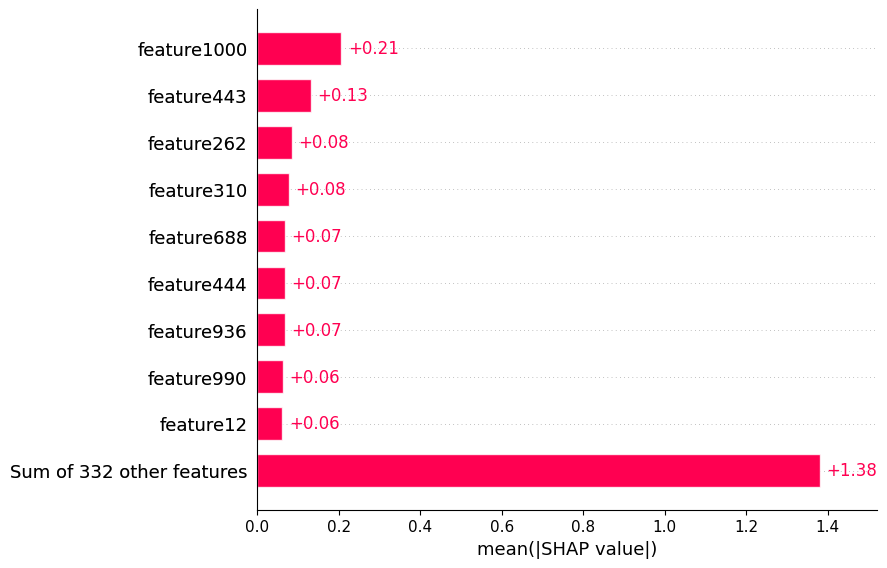

In [17]:
light_gbm = lgb.LGBMClassifier(n_estimators=100, random_state=42, max_depth=10)
light_gbm.fit(X_train, y_train)
light_gbm_proba = light_gbm.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, light_gbm_proba)
print(f"LightGBM ROC-AUC: {roc_auc}")
explainer = shap.Explainer(light_gbm, X_train)
shap_values = explainer(X_val)
shap.plots.bar(shap_values.abs.mean(0))
shap_sum = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
feature_importance.columns = ['feature', 'shap_importance']
feature.update(feature_importance["feature"][feature_importance["shap_importance"] > 0])

### SHAP для XGBoost

XGBoost ROC-AUC: 0.6645954350635755


100%|===================| 77831/77942 [16:40<00:01]        

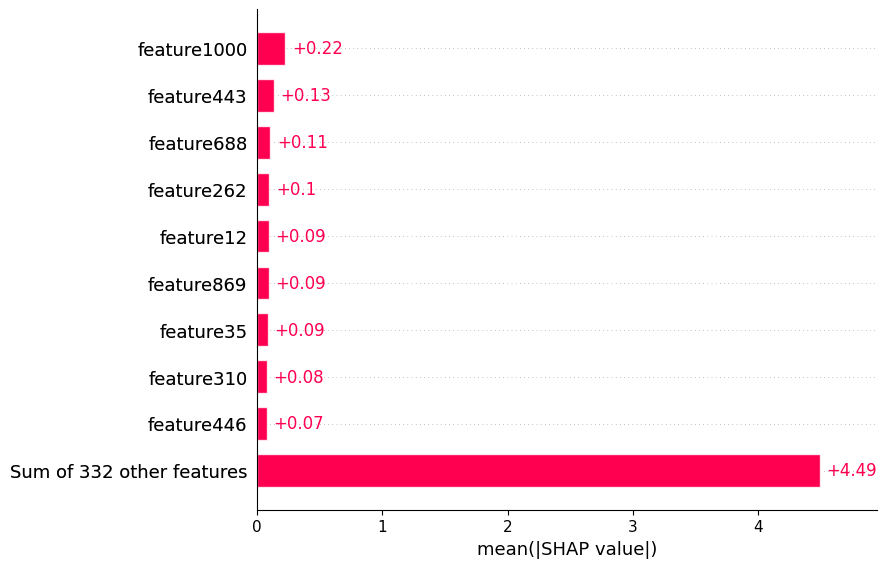

In [18]:
light_gbm = XGBClassifier(n_estimators=100, random_state=42, max_depth=10)
light_gbm.fit(X_train, y_train)
light_gbm_proba = light_gbm.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, light_gbm_proba)
print(f"XGBoost ROC-AUC: {roc_auc}")
explainer = shap.Explainer(light_gbm, X_train)
shap_values = explainer(X_val)
shap.plots.bar(shap_values.abs.mean(0))
shap_sum = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
feature_importance.columns = ['feature', 'shap_importance']
feature.update(feature_importance["feature"][feature_importance["shap_importance"] > 0])

### SHAP для Random Forest 

XGBoost ROC-AUC: 0.6846139049884719


100%|===================| 155846/155884 [42:18<00:00]        

TypeError: 'numpy.float64' object is not iterable

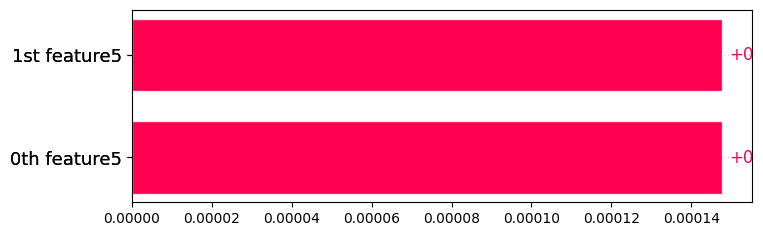

In [19]:
light_gbm = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
light_gbm.fit(X_train, y_train)
light_gbm_proba = light_gbm.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, light_gbm_proba)
print(f"XGBoost ROC-AUC: {roc_auc}")
explainer = shap.Explainer(light_gbm, X_train)
shap_values = explainer(X_val)
shap.plots.bar(shap_values.abs.mean(0))
shap_sum = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
feature_importance.columns = ['feature', 'shap_importance']
feature.update(feature_importance["feature"][feature_importance["shap_importance"] > 0])

In [24]:
X_train, X_val, X_test = X_train[list(feature)], X_val[list(feature)], X_test[list(feature)]

In [26]:
X_train

,feature784,feature773,feature303,feature473,feature300,feature112,feature755,feature675,feature690,feature202,...,feature552,feature170,feature713,feature563,feature758,feature109,feature891,feature277,feature199,feature927
305172,57,35,10765,121,23278,10467,1,0,0,11298,...,23,162919,1,3,1,1651,0,10477,79766,0
180948,57,35,1604,121,23278,10467,1,1,2,11298,...,0,61603,1,3,1,75317,137,10477,74921,31
319360,57,35,10765,121,23278,10467,1,1,1,11298,...,0,72008,1,3,1,1058,66,10477,19322,31
9967,57,35,8533,121,23278,10467,1,1,1,11298,...,23,162919,0,3,1,76889,137,10477,79766,31
336341,57,35,10765,121,23278,10467,1,1,1,11298,...,23,162919,1,3,1,2059,137,10477,79766,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346164,57,16,10765,121,22079,10467,1,1,3,11298,...,0,50141,1,3,1,21663,37,5129,32184,21
488156,57,35,10765,121,23278,658,1,1,2,11298,...,23,43642,1,3,1,28310,137,10477,79766,31
176273,57,35,10765,121,23278,10467,1,1,1,11298,...,3,162919,1,3,1,76889,89,10477,75136,31
196223,57,35,1938,0,23278,160,1,1,3,11298,...,23,67205,1,3,1,48750,0,10477,79766,31


In [25]:
params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'gain',
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0,
    'n_estimators': 10000,
    'num_leaves': 31,
    'objective': "binary",
    'random_state': 9,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'metric': 'auc',
    'gpu_use_dp': True,
    "early_stopping_rounds":300
}

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

lightgbm = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, val_data])
y_train_pred = lightgbm.predict(X_train)
y_val_pred = lightgbm.predict(X_val)

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_val, y_val_pred)
print(f"roc-auc train {roc_auc_train}")
print(f"roc-auc test {roc_auc_test}")

c:\Users\Александр\Desktop\УЧЕБА\ХАКАТОНЫ\IT Purple Hack\purple_hack\venv\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 13005, number of negative: 350725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43194
[LightGBM] [Info] Number of data points in the train set: 363730, number of used features: 307
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035755 -> initscore=-3.294669
[LightGBM] [Info] Start training from score -3.294669
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[90]	training's auc: 0.794938	valid_1's auc: 0.703342
roc-auc train 0.7949381941822109
roc-auc t

In [27]:
y_train_pred = lightgbm.predict(X_train)
y_test_pred = lightgbm.predict(X_test)

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f"roc-auc train {roc_auc_train}")
print(f"roc-auc test {roc_auc_test}")

roc-auc train 0.7949381941822109
roc-auc test 0.6960129056266595
